In [1]:
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#from itertools import chain

from protonvsalpha import * 
from utils import *

%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
REBUILD_DATA = False

if REBUILD_DATA:

    calibs = {
        18: [147.0523954 , 6.881080265],
        19: [81.04737894 , 7.085739671],
        20: [134.4130931 , 6.867303884],  
        21: [52.49156769 , 6.977710698],
        22: [115.6844003 , 6.972525191],
        23: [105.7124417 , 7.014689067],
        24: [141.2088713 , 6.819153484],
        25: [101.7931871 , 6.912542255],
        26: [106.9610586 , 6.803011239],
        27: [113.200237	 , 6.872037915],
        28: [156.9549588 , 6.729815827],
        29: [166.1025889 , 6.859329979],
        30: [132.8376939 , 6.714517249],
        31: [99.10092281 , 6.926500923],
    }
    
    #to change with new cuts
    cutp = rt.TCutG('myCut',5) 
    cutp.SetPoint(0,69,5214)                                                      
    cutp.SetPoint(1,22,2173)                                                       
    cutp.SetPoint(2,23,3372)                                                        
    cutp.SetPoint(3,58,5326)                                                       
    cutp.SetPoint(4,69,5214)
    
    cuta = rt.TCutG('myCut2',5)
    cuta.SetPoint(0,89,7223)
    cuta.SetPoint(1,33,4131)
    cuta.SetPoint(2,45,6506)   
    cuta.SetPoint(3,88,8339)
    cuta.SetPoint(4,89,7223)   



    protonvsalpha1 = ProtonVsAlpha(
        "rudata_gal-10_ru5_s78_r4025.root", 
            100, 1000000, range(18,31), calibs, cutp, cuta)
    protonvsalpha1.make_training_data("dataset")
 

In [3]:
training_data = np.load("dataset.npy", allow_pickle = True)

print(len(training_data))

470435


In [4]:
#balance data
count_p = 0
count_a = 0
count_b = 0
new_training_data = []
for i in range(len(training_data)):
    if (training_data[i][1][0]==1) & (count_p<13000): #is a proton
        new_training_data.append(training_data[i])
        count_p +=1
    if (training_data[i][1][1]==1) & (count_a<13000): #is a proton
        new_training_data.append(training_data[i])
        count_a +=1
    if (training_data[i][1][2]==1) & (count_b<13000): #is a proton
        new_training_data.append(training_data[i])
        count_b +=1
print(count_p,count_a, count_b)

training_data = new_training_data
np.random.shuffle(training_data)
print(len(training_data))

13000 13000 13000
39000


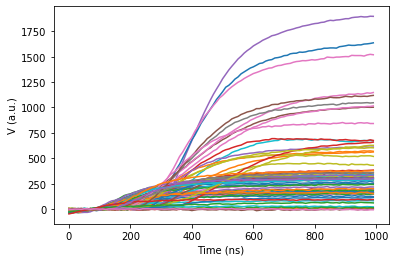

In [9]:
for i in range(200):
    if training_data[i][1][2]==1:
        plt.plot(range(0,1000,10),training_data[i][0])
plt.xlabel("Time (ns)")
plt.ylabel("V (a.u.)")
plt.savefig("other.png", dpi = 200)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100,64)
        self.fc2 = nn.Linear(64, 64)
        #self.fc1 = nn.Conv1d(1, 10, 3)
        #self.fc2 = nn.Linear(980, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc1(x)).view([-1, 980])
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        return F.softmax(x, dim=1)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)


In [7]:
import torch.optim as optim

#optimizer = optim.Adam(net.parameters(), lr = 0.001)
optimizer = optim.Adamax(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 100)
X = X/800.0
y = torch.Tensor([i[1] for i in training_data])
print(X.shape)
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

torch.Size([39000, 100])
3900


In [8]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

35100
3900


In [9]:
def train(net):
    BATCH_SIZE = 200
    #BATCH_SIZE = 20
    EPOCHS = 30
    #EPOCHS = 50

    for epoch in range(EPOCHS):
        for i in range(0,len(train_X), BATCH_SIZE):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,100)
            #batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,100)
            batch_y = train_y[i:i+BATCH_SIZE]
        
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        if (epoch%10==0):    
            print(f"Epoch: {epoch}. Loss: {loss/BATCH_SIZE}")


def test(net):
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            y_true.append(real_class)
            net_out = net(test_X[i].view(-1, 100))[0]  # returns a list, 
            #net_out = net(test_X[i].view(-1, 1, 100))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)
            y_pred.append(predicted_class)
            if predicted_class == real_class:
                correct += 1
            #else: 
            #    plt.plot(test_X[i])
            #    print(real_class)
            total += 1
    #print(y_true)
    
    print("Accuracy: ", round(correct/total, 4))
    plot_confusion_matrix(y_true, y_pred, classes=["proton","alpha","none"],normalize=True,
                     title='Confusion matrix')


In [16]:
train(net)

Epoch: 0. Loss: 8.649845403851941e-05
Epoch: 10. Loss: 8.495169458910823e-05
Epoch: 20. Loss: 8.266563236247748e-05


100%|██████████| 3900/3900 [00:00<00:00, 5835.33it/s]


Accuracy:  0.9397
Normalized confusion matrix
[[0.95635528 0.00612557 0.03751914]
 [0.02164179 0.97537313 0.00298507]
 [0.08293461 0.03269537 0.88437002]]


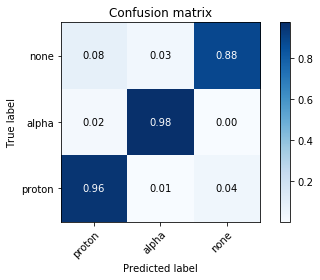

In [17]:
test(net)

In [18]:
#export model for c++
example = torch.rand(1, 1, 100)
traced_script_module = torch.jit.trace(net, example)
traced_script_module.save("traced_net_gal_10.pt")